In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle.json'

In [58]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
  !ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 64 Aug 10 00:05 kaggle.json
{"username":"diptaroy","key":"c4c1899a45f60acb8e710d7a4e0afb05"}

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 5.3MB 4.8MB/s 
     |████████████████████████████████| 133kB 41.0MB/s 
     |████████████████████████████████| 112kB 37.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "diptaroy" # username from the json file
os.environ['KAGGLE_KEY'] = "c4c1899a45f60acb8e710d7a4e0afb05" # key from the json file

In [2]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:43<00:00, 105MB/s] 
100% 3.10G/3.10G [00:43<00:00, 76.7MB/s]


In [3]:
!unzip -q breast-histopathology-images.zip 

In [ ]:
images_folder = '/content/IDC_regular_ps50_idx5'

In [4]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
# from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#let's take a look at if we're in the right folder
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:15]:
    print(filename)

/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1901_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1451_y1451_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1151_y1601_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1301_y1551_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1651_y1351_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1901_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1351_y1951_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1401_y1701_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1851_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1701_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1551_y1801_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1801_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1401_y1651_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x

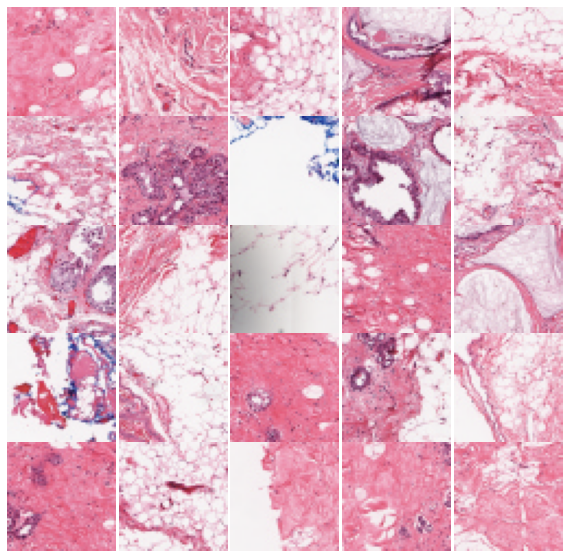

In [ ]:
#let's look at the first 25 images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [6]:
classZero = '*class0.png'
classOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, classZero)
classOne = fnmatch.filter(imagePatches, classOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1251_y2051_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1251_y1151_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x551_y1051_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1201_y1101_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png'] 

IDC(+)

 ['/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1901_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1451_y1451_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1151_y1601_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1301_y1551_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1651_y1351_class1.png']


In [7]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 50
    HEIGHT = 50

    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
        patient.append(img)


        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y, patient

In [8]:
def only_ones(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 50
    HEIGHT = 50

    for img in imagePatches[lowerIndex:upperIndex]:

        if img in classOne:
            full_size_image = cv2.imread(img)
            x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
            patient.append(img)
            y.append(1)
        elif img in classZero:
            continue
        else:
            return
    return x,y, patient

In [9]:
from os import listdir
base_path = "/content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)


total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
total_images

277524

In [10]:
A,B, patient1 = proc_images(0,50000)


In [11]:
#we have a huge imbalance so let's pull some positives 
C,D, patient2 = only_ones(50001,80000)


In [12]:
X = np.concatenate([A, C], axis=0)
Y = np.concatenate([B, D], axis=0)
patient = np.concatenate([patient1, patient2], axis=0)

In [12]:
X.shape

(50495, 50, 50, 3)

In [13]:
df1= pd.DataFrame()
df1["images"]=A
df1["labels"]=B
df1['id']=patient1
df2 = pd.DataFrame()
df2['images']=C
df2['labels']=D
df2['id'] = patient2

df= pd.concat([df1,df2])

X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] # these come in later when we want to visualize the differences between IDC(-) and IDC(+)

In [14]:
X_test, Y_test, patient = proc_images(80001,100000)


In [15]:
#To add patient ID to the dataframe
# df['id'] = patient
df['patient_id']=df['id'].apply(lambda x: x.split('/')[3])
df.drop(labels='id', axis=1, inplace=True)

In [ ]:
df.labels.value_counts().sum()

39924

In [ ]:
df2.shape

(19924, 3)

In [ ]:
df[df['labels']==1].head(2)

,images,labels
0,"[[[134, 75, 135], [176, 128, 191], [157, 105, ...",1
1,"[[[211, 184, 205], [206, 181, 205], [182, 144,...",1


In [ ]:
df.groupby("patient_id").size()

patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Length: 279, dtype: int64

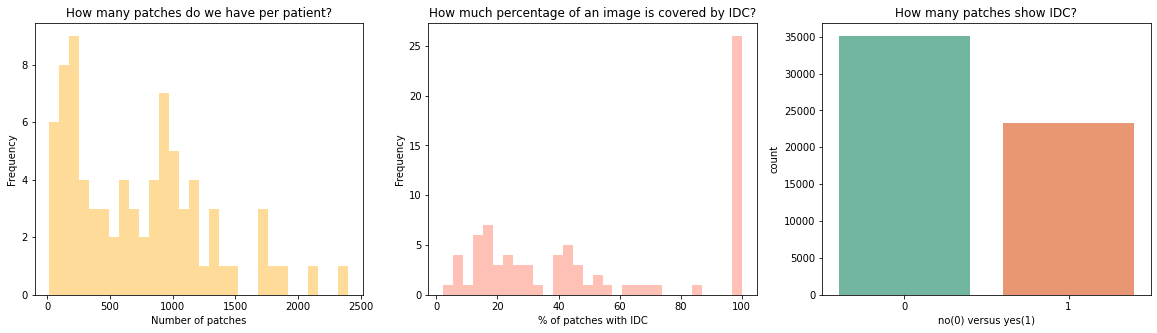

In [16]:
cancer_perc = df.groupby("patient_id").labels.value_counts()/ df.groupby("patient_id").labels.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(df.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(df.labels, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

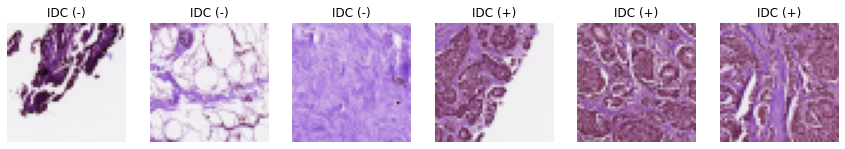

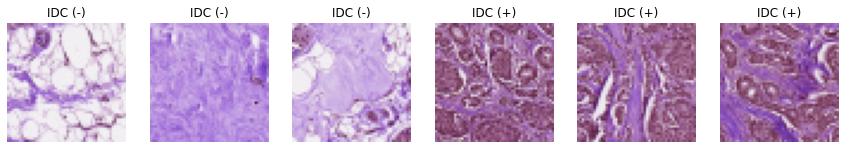

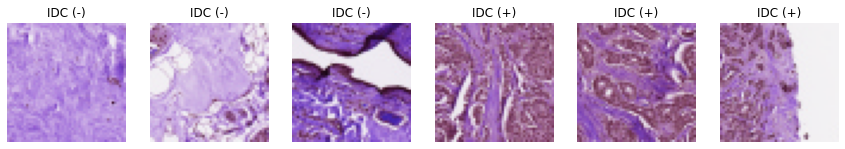

In [17]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      20000 non-null  object
 1   labels      20000 non-null  int64 
 2   patient_id  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [ ]:
# from keras.utils.np_utils import to_categorical
# Y = to_categorical(Y, num_classes = 2)

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
# X_train, X_val, Y_train, Y_val = train_test_split(X_model, Y_model, test_size=0.2)

In [19]:
from keras.utils.np_utils import to_categorical
X_train=np.array(X_train)/255
y_trainHot = to_categorical(Y_train, num_classes = 2)

X_test=np.array(X_test)/255
y_testHot = to_categorical(Y_test, num_classes = 2)

X_val=np.array(X_val)/255
y_valHot = to_categorical(Y_val, num_classes = 2)

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3),strides=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,360,578
Trainable params: 2,360,578
Non-trainable params: 0
_________________________________________________________________


In [73]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(X_train, y_trainHot ,batch_size=10,epochs = 15, validation_data=(X_val, y_valHot))

Epoch 1/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3835 - accuracy: 0.8301 - val_loss: 0.3986 - val_accuracy: 0.8200
Epoch 2/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3760 - accuracy: 0.8334 - val_loss: 0.4922 - val_accuracy: 0.7892
Epoch 3/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3697 - accuracy: 0.8383 - val_loss: 0.4084 - val_accuracy: 0.8131
Epoch 4/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3622 - accuracy: 0.8426 - val_loss: 0.4052 - val_accuracy: 0.8217
Epoch 5/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3541 - accuracy: 0.8474 - val_loss: 0.4022 - val_accuracy: 0.8266
Epoch 6/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3454 - accuracy: 0.8522 - val_loss: 0.3910 - val_accuracy: 0.8300
Epoch 7/15
4672/4672 [==============================] - 14s 3ms/step - loss: 0.3347 - accuracy: 0.8563 - val_loss: 0.3970 - val_ac

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


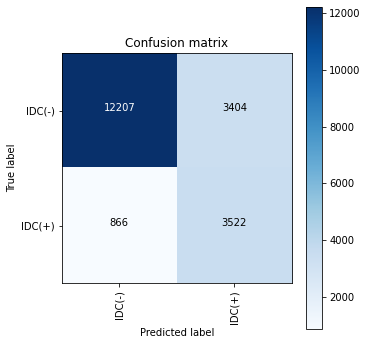

In [74]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [75]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))

              precision    recall  f1-score   support

     IDC (-)       0.93      0.78      0.85     15611
     IDC (+)       0.51      0.80      0.62      4388

    accuracy                           0.79     19999
   macro avg       0.72      0.79      0.74     19999
weighted avg       0.84      0.79      0.80     19999



In [78]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 2 , activation = 'sigmoid'))
# model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 64)       

In [79]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(X_train, y_trainHot ,batch_size=64,epochs = 15, validation_data=(X_val, y_valHot), callbacks=[learning_rate_reduction])

Epoch 1/15
730/730 [==============================] - 7s 9ms/step - loss: 0.4184 - accuracy: 0.8216 - val_loss: 1.0839 - val_accuracy: 0.4127
Epoch 2/15
730/730 [==============================] - 6s 8ms/step - loss: 0.3595 - accuracy: 0.8455 - val_loss: 0.5380 - val_accuracy: 0.7176
Epoch 3/15
730/730 [==============================] - 6s 8ms/step - loss: 0.3456 - accuracy: 0.8536 - val_loss: 0.7609 - val_accuracy: 0.5724
Epoch 4/15
730/730 [==============================] - 6s 8ms/step - loss: 0.3360 - accuracy: 0.8572 - val_loss: 0.3574 - val_accuracy: 0.8395
Epoch 5/15
730/730 [==============================] - 6s 8ms/step - loss: 0.3240 - accuracy: 0.8633 - val_loss: 0.6007 - val_accuracy: 0.7551
Epoch 6/15
729/730 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8668
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
730/730 [==============================] - 6s 8ms/step - loss: 0.3146 - accuracy: 0.8668 - val_loss: 0.9143 - val_

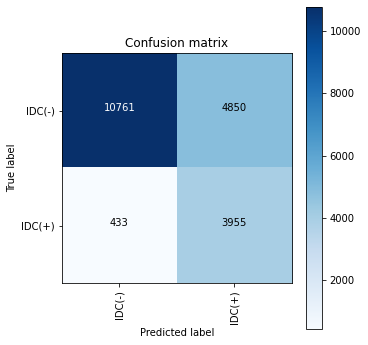

In [80]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))

              precision    recall  f1-score   support

     IDC (-)       0.96      0.80      0.87     16053
     IDC (+)       0.52      0.86      0.65      3946

    accuracy                           0.81     19999
   macro avg       0.74      0.83      0.76     19999
weighted avg       0.87      0.81      0.83     19999



In [29]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
    def __len__(self):
        return self.steps_per_epoch
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [30]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        rescale=1/255.0,
        horizontal_flip=True,
        vertical_flip=True) # define your data augmentation
balanced_gen = BalancedDataGenerator(X_train, y_trainHot, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
balanced_gen

In [32]:
model.fit_generator(balanced_gen, epochs=3, steps_per_epoch=steps_per_epoch, validation_data=(X_val, y_valHot))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1362/1362 [==============================] - 38s 28ms/step - loss: 0.4547 - accuracy: 0.8033 - val_loss: 1954390.5000 - val_accuracy: 0.5337
Epoch 2/3
1362/1362 [==============================] - 38s 28ms/step - loss: 0.4040 - accuracy: 0.8225 - val_loss: 1735173.3750 - val_accuracy: 0.5337
Epoch 3/3
1362/1362 [==============================] - 38s 28ms/step - loss: 0.3922 - accuracy: 0.8288 - val_loss: 1636477.3750 - val_accuracy: 0.5337


{0: 'IDC(-)', 1: 'IDC(+)'}


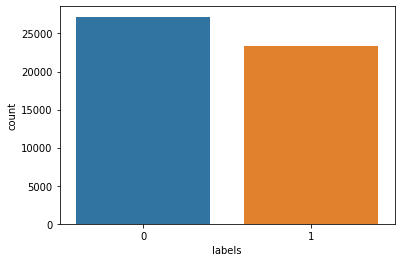

In [33]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{0: 'IDC(-)', 1: 'IDC(+)'}


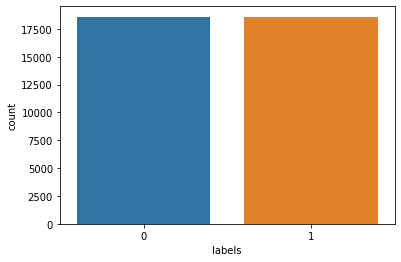

In [34]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [ ]:
df_val = pd.DataFrame(y_valHot)
df_val.describe()

,0,1
count,1600.000000,1600.000000
mean,0.799375,0.200625
std,0.400596,0.400596
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [35]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./loss_curve.png')

In [36]:
batch_size = 128
num_classes = 2
epochs = 8
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=e))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [38]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [39]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot
epochs = 10

In [40]:
history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        epochs=epochs, validation_data=(X_val, y_valHot))

Epoch 1/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.5768 - accuracy: 0.7022 - val_loss: 0.4792 - val_accuracy: 0.7882
Epoch 2/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.5000 - accuracy: 0.7740 - val_loss: 0.4758 - val_accuracy: 0.7854
Epoch 3/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.4754 - accuracy: 0.7852 - val_loss: 0.4492 - val_accuracy: 0.7993
Epoch 4/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.4591 - accuracy: 0.7950 - val_loss: 0.4298 - val_accuracy: 0.8090
Epoch 5/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.4489 - accuracy: 0.7992 - val_loss: 0.4487 - val_accuracy: 0.8009
Epoch 6/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.4417 - accuracy: 0.8046 - val_loss: 0.4266 - val_accuracy: 0.8077
Epoch 7/10
1263/1263 [==============================] - 30s 24ms/step - loss: 0.4357 - accuracy: 0.8059 - val_loss: 0.4193 -

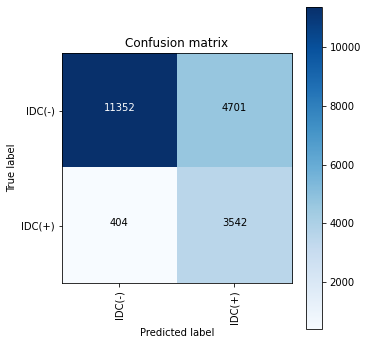

In [41]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()